In [1]:
%pylab inline
%load_ext Cython
import numpy as np
import scipy as sp
import pandas as pd
import pylab
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set_style('darkgrid')

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%cython --cplus --compile-args=-O3 --compile-args=-std=c++11


cimport cython

from cython.parallel import parallel, prange
from libc.stdlib cimport abort, malloc, free
from libcpp.unordered_map cimport unordered_map

from random import random


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef get_children(int max_level, list level_vector, float T):
    cdef list result = []
    cdef int dim = len(level_vector)
    if (sum(level_vector) - T*max(level_vector) < (max_level + dim - 1) - T*max_level) and (max(level_vector) <= max_level):
        for d in xrange(dim):
            lvec = list(level_vector)
            lvec[d] += 1
            result.append(list(lvec))
        return result
    else:
        return []
    
    
@cython.boundscheck(False)
@cython.wraparound(False)    
def create_grid_iter(list root_level_vector, int max_level, float T):
    '''
    Iterative creation of a random graph
    '''
    cdef int i
    working_set = {tuple(root_level_vector) : 0}
    Q = []
    Q.append((0, root_level_vector))
    while len(Q):
        seq, level_vector = Q.pop(0)
        children_list = get_children(max_level, level_vector, T)
        if level_vector == [2, 2, 1, 1]:
            print "child list", children_list
        N = len(children_list)
        for i in range(N):
            clvec = children_list[i]
            ckey = tuple(clvec)
            if not working_set.has_key(ckey):
                cseq = len(working_set)
                working_set[ckey] = cseq
                tpl = (cseq, list(clvec))
                Q.append(tpl)
    return working_set

In [4]:
D = 4
l_max = 3
Ts = [1.0]
#Ts = [-1, 0.0, 0.5, 0.9, 1.0]
exp_size = len(Ts)
results = np.zeros((D+1,exp_size))

In [5]:
root_level_vector = [1]*D
for exp_num, T in enumerate(Ts):
    grid = create_grid_iter(root_level_vector, l_max, T)
    print len(grid.keys()),len(unique(map(str,grid.keys()))), grid.keys()
    grid_points = {}
    for level_vector in grid.keys():
        key = tuple([i for i in xrange(D) if level_vector[i] > 1 ])
        num_points = np.prod([2**(level_vector[i]-1) for i in xrange(D)])
        if grid_points.has_key(key):
            grid_points[key] += num_points
        else:
            grid_points[key] = num_points

    grid_points_pd = pd.DataFrame(columns=['order', 'points'])


    for i,(key,val) in enumerate(grid_points.iteritems()):
        grid_points_pd.loc[i] = [len(key),val]

    summary = grid_points_pd.groupby('order').sum()
    for d, n in enumerate(summary.as_matrix().flatten()):
        results[d, exp_num] = n

1 1 [(1, 1, 1, 1)]


In [6]:
df = pd.DataFrame(results, columns=Ts )

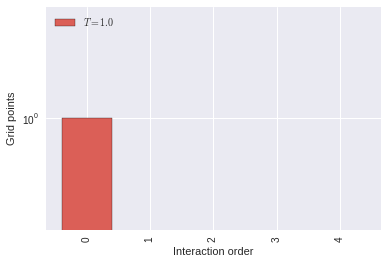

In [7]:
pylab.figure()
sns.set_palette('hls', n_colors=exp_size)
df.plot(kind='bar', width=0.8)
sns.set_palette('hls', n_colors=exp_size)

pylab.xlabel('Interaction order')
pylab.ylabel('Grid points')
pylab.yscale('log')
pylab.legend([r'$T=%.1f$'%T for T in Ts ], loc='upper left')

In [8]:
results

array([[ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [10]:
import pysgpp
def getGridSize(d,l,T):
    grid = pysgpp.Grid.createModLinearGrid(d)
    gen = grid.getGenerator()
    gen.regular(l,T)
    print str(T) + "\t" + str(grid.getStorage().getSize())  
dim = 4

for i in range(0,11):
    getGridSize(10,5,i/10.0)


0.0	13441
0.1	2161
0.2	2161
0.3	2161
0.4	1201
0.5	1201
0.6	481
0.7	301
0.8	301
0.9	301
1.0	301


In [3]:
def plot_grid_2d(level, T):
    grid = pysgpp.Grid.createModLinearGrid(2)
    gen = grid.getGenerator()
    gen.regular(level,T)
    storage = grid.getStorage()
    size = grid.getSize()
    indices = []
    for i in range(0, size):
        index = storage.get(i)
        x_pos = index.getCoord(0)
        y_pos = index.getCoord(1)
        indices.append( (x_pos,y_pos) )
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("{} gridpoints for level = {} with T = {}".format(size, level, T))
    ax.set_axis_off()
    x,y = zip(*indices)
    ax.scatter(x, y)    
    
def plot_grid_3d(level, T):
    grid = pysgpp.Grid.createLinearGrid(3)
    gen = grid.getGenerator()
    gen.regular(level,T)
    storage = grid.getStorage()
    size = grid.getSize()
    indices = []
    for i in range(0, size):
        index = storage.get(i)
        x_pos = index.getCoord(0)
        y_pos = index.getCoord(1)
        z_pos = index.getCoord(2)
        indices.append( (x_pos,y_pos, z_pos) )
    x,y,z = zip(*indices)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("{} gridpoints for level = {} with T = {}".format(size, level, T))
    ax.scatter(x, y, z)    

In [17]:
getGridSize(8,5,0.5)

0.5	801


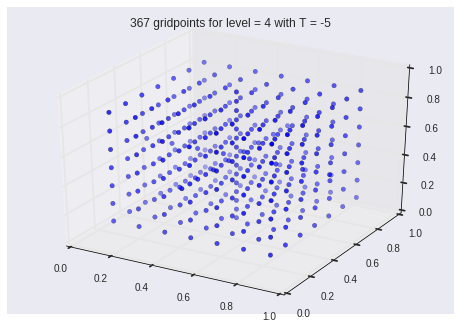

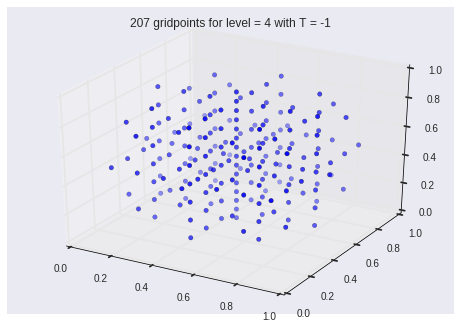

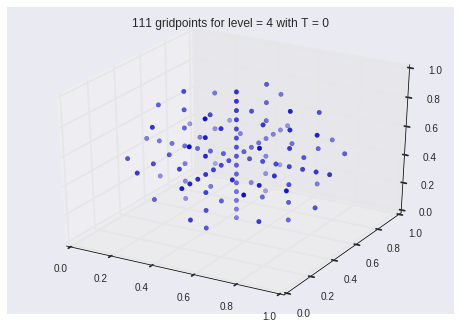

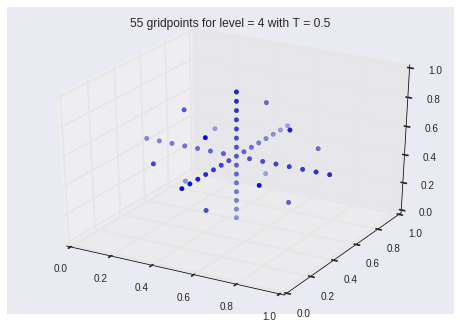

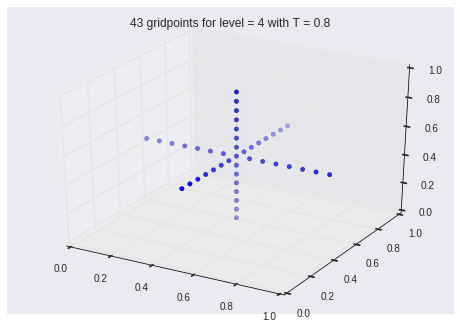

In [5]:
plot_grid_3d(4, -5)
plot_grid_3d(4, -1)
plot_grid_3d(4, 0)
plot_grid_3d(4, 0.5)
plot_grid_3d(4, 0.8)

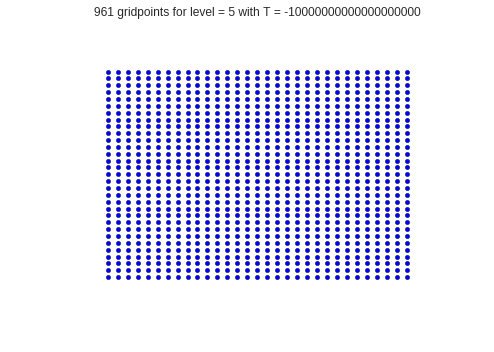

In [31]:
plot_grid_2d(5, -10000000000000000000)

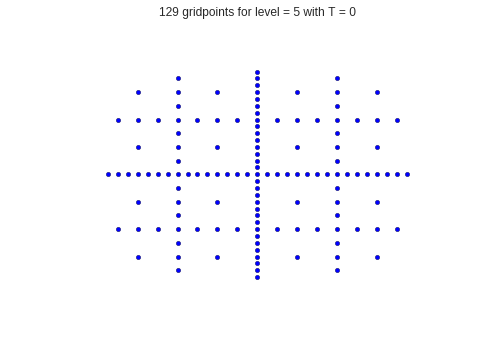

In [34]:
plot_grid_2d(5,0)